In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()
%matplotlib inline

In [57]:
import psycopg2


postgresDb = psycopg2.connect(
    host="localhost",
    database="postgres",
    user="postgres",
    password="admin")

In [58]:
class Stockdatadao:
    def __init__(self, db):
        self.db = db

    def select(self, symbol):
        cursor = self.db.cursor()
        sql = """SELECT date_time, open, high, low, close, volume, adj_close
                    FROM stock_data WHERE symbol = %s"""
        val = (symbol,)

        cursor.execute(sql, val)
        result = cursor.fetchall()
        list_stock_data = []

        for item in result:
            list_stock_data.append(
                StockDataViewModel(date_time=item[0], open=item[1], high=item[2], low=item[3],
                                   close=item[4], volume=item[5], adj_close=item[6]))

        cursor.close()
        if result is None:
            return None
        else:
            return list_stock_data


class StockDataViewModel:
    def __init__(self, date_time, open, high, low, close, volume, adj_close):
        self.date_time = date_time
        self.open = open
        self.high = high
        self.low = low
        self.close = close
        self.volume = volume
        self.adj_close = adj_close

    def to_dict(self):
        return {
            'date_time': self.date_time,
            'open': self.open,
            'high': self.high,
            'low': self.low,
            'close': self.close,
            'volume': self.volume,
            'adj_close': self.adj_close
        }

In [59]:
stock_data_dao = Stockdatadao(postgresDb)

stock_data = stock_data_dao.select('AAPL')

df = pd.DataFrame([s.to_dict() for s in stock_data], columns=['date_time', 'open', 'high', 'low', 'close', 'volume', 'adj_close'])

df = df.rename(columns={'date_time': 'date'})

df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df.sort_index(inplace=True)
df['volume'] = df['volume'].astype(float)
print(df.head(10))

                open      high       low     close       volume  adj_close
date                                                                      
1980-12-12  0.128348  0.128906  0.128348  0.128348  469033600.0   0.099584
1980-12-15  0.122210  0.122210  0.121652  0.121652  175884800.0   0.094388
1980-12-16  0.113281  0.113281  0.112723  0.112723  105728000.0   0.087461
1980-12-17  0.115513  0.116071  0.115513  0.115513   86441600.0   0.089625
1980-12-18  0.118862  0.119420  0.118862  0.118862   73449600.0   0.092224
1980-12-19  0.126116  0.126674  0.126116  0.126116   48630400.0   0.097852
1980-12-22  0.132254  0.132813  0.132254  0.132254   37363200.0   0.102614
1980-12-23  0.137835  0.138393  0.137835  0.137835   46950400.0   0.106945
1980-12-24  0.145089  0.145647  0.145089  0.145089   48003200.0   0.112573
1980-12-26  0.158482  0.159040  0.158482  0.158482   55574400.0   0.122964


In [60]:
###get the dataset of AAPL stock from 2013-01-01 to 2023-06-01 from df
df = df.loc['2013-01-01':'2023-06-29']

print(df.last('3D'))

                  open        high         low       close      volume  \
date                                                                     
2023-06-27  185.889999  188.389999  185.669998  188.059998  50730800.0   
2023-06-28  187.929993  189.899994  187.600006  189.250000  51216800.0   
2023-06-29  189.080002  190.070007  188.940002  189.589996  46126000.0   

             adj_close  
date                    
2023-06-27  188.059998  
2023-06-28  189.250000  
2023-06-29  189.589996  


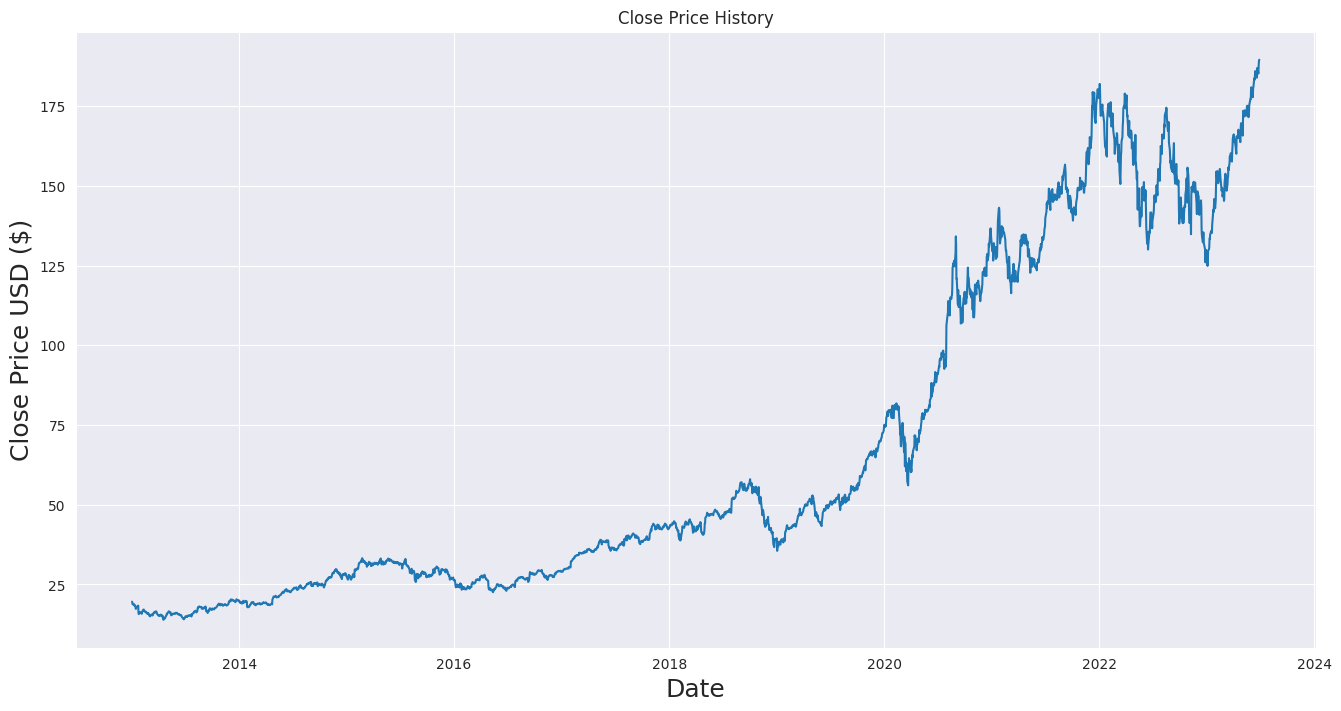

In [61]:
###plot the close price history of AAPL stock from 2013-01-01 to 2023-06-01 from df using matplotlib

plt.figure(figsize=(16, 8))
plt.title('Close Price History')
plt.plot(df['close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [62]:
#adding a field to the data set for calculating the mean of high and low price in df

df['Mean'] = (df['high'] + df['low']) / 2.0

df.head(2)

,open,high,low,close,volume,adj_close,Mean
date,,,,,,,
2013-01-02,19.779285,19.821428,19.343929,19.608213,560518000.0,16.813864,19.582679
2013-01-03,19.567142,19.631071,19.321428,19.360714,352965200.0,16.601629,19.476250


In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2641 entries, 2013-01-02 to 2023-06-29
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       2641 non-null   float64
 1   high       2641 non-null   float64
 2   low        2641 non-null   float64
 3   close      2641 non-null   float64
 4   volume     2641 non-null   float64
 5   adj_close  2641 non-null   float64
 6   Mean       2641 non-null   float64
dtypes: float64(7)
memory usage: 165.1 KB


In [64]:
#We need to restructure the data set by adding a target column ‘Actual’, which will the stock prices for the next day.

steps=-1
dataset_for_prediction = df.copy()
dataset_for_prediction['Actual'] = dataset_for_prediction['Mean'].shift(steps)
dataset_for_prediction.head(3)

,open,high,low,close,volume,adj_close,Mean,Actual
date,,,,,,,,
2013-01-02,19.779285,19.821428,19.343929,19.608213,560518000.0,16.813864,19.582679,19.476250
2013-01-03,19.567142,19.631071,19.321428,19.360714,352965200.0,16.601629,19.476250,19.008214
2013-01-04,19.177500,19.236786,18.779642,18.821428,594333600.0,16.139196,19.008214,18.651785


In [65]:
##dropping columns with null values in dataset_for_prediction

dataset_for_prediction = dataset_for_prediction.dropna()

Text(0.5, 1.0, ' Apple Stock Value')

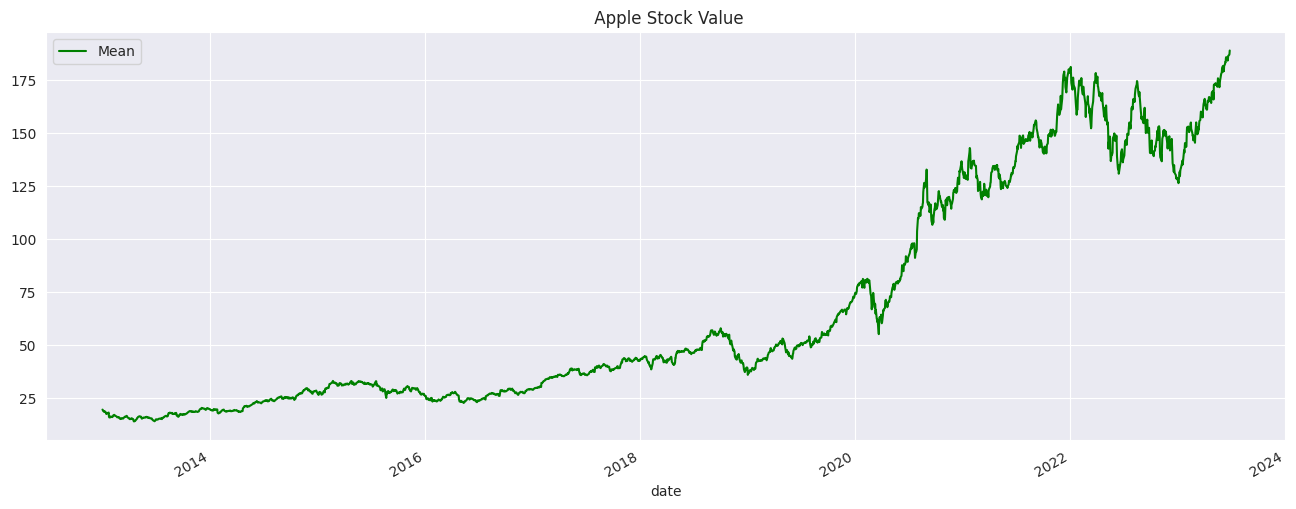

In [66]:
#plot the mean stock prices for the current dataset and lock the trends from df

dataset_for_prediction['Mean'].plot(color='green', figsize=(16, 6))
plt.legend(['Mean'])
plt.title(" Apple Stock Value")

Text(0.5, 1.0, ' Apple Stock Volume')

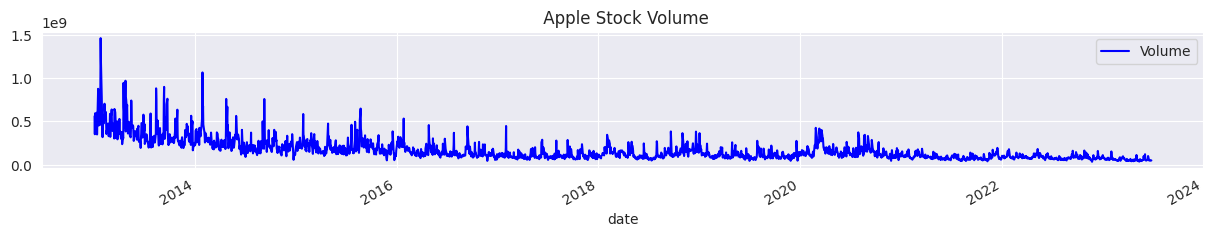

In [67]:
#Plotting volume of Apple stocks sold daily from df

dataset_for_prediction['volume'].plot(color='blue', figsize=(15, 2))
plt.legend(['Volume'])
plt.title(" Apple Stock Volume")

In [68]:
#Normalizing the input and target features
#Since the stock prices and volume are on a different scale, we need to normalize the data. We use MinMaxScaler; it will scale the data to a fixed range between 0 to 1
# Scaling the input features- Low, High, Open, Close, Volume, Adjusted Close, and Mean

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_input = scaler.fit_transform(dataset_for_prediction[['low', 'high', 'open', 'close', 'volume', 'adj_close', 'Mean']])
scaled_input = pd.DataFrame(scaled_input)

X = scaled_input
X.head(2)

,0,1,2,3,4,5,6
0,0.032157,0.031601,0.034027,0.032291,0.368477,0.026996,0.031877
1,0.032027,0.030517,0.032808,0.030879,0.222893,0.025799,0.031268


In [69]:
#Scaling the target feature- Actual (Mean of High and Low) price

sc_out = MinMaxScaler(feature_range=(0, 1))
scaled_output = sc_out.fit_transform(dataset_for_prediction[['Actual']])

scaler_output = pd.DataFrame(scaled_output)

y = scaler_output
y.head(2)

,0
0,0.031134
1,0.028467


In [70]:
X.rename(columns={0: 'low', 1: 'high', 2: 'open', 3: 'close', 4: 'volume', 5: 'adj_close', 6: 'Mean'}, inplace=True)
X.index=dataset_for_prediction.index
X.head(2)

,low,high,open,close,volume,adj_close,Mean
date,,,,,,,
2013-01-02,0.032157,0.031601,0.034027,0.032291,0.368477,0.026996,0.031877
2013-01-03,0.032027,0.030517,0.032808,0.030879,0.222893,0.025799,0.031268


In [71]:
#renaming the target variable

y.rename(columns={0: 'Stock Price Next Day'}, inplace=True)
y.index=dataset_for_prediction.index

y.head(2)

,Stock Price Next Day
date,
2013-01-02,0.031134
2013-01-03,0.028467


In [72]:
#Splitting the dataset into training and testing sets

train_size = int(len(df) * 0.80)
test_size = int(len(df) - train_size)
print(test_size)

529


In [73]:
#Splitting the dataset into training and testing sets using train_size and test_size from df and y respectively
train_X, train_Y = X[:train_size].dropna(), y[:train_size].dropna()
test_X, test_Y = X[train_size:].dropna(), y[train_size:].dropna()

In [74]:
test_X.columns

Index(['low', 'high', 'open', 'close', 'volume', 'adj_close', 'Mean'], dtype='object')

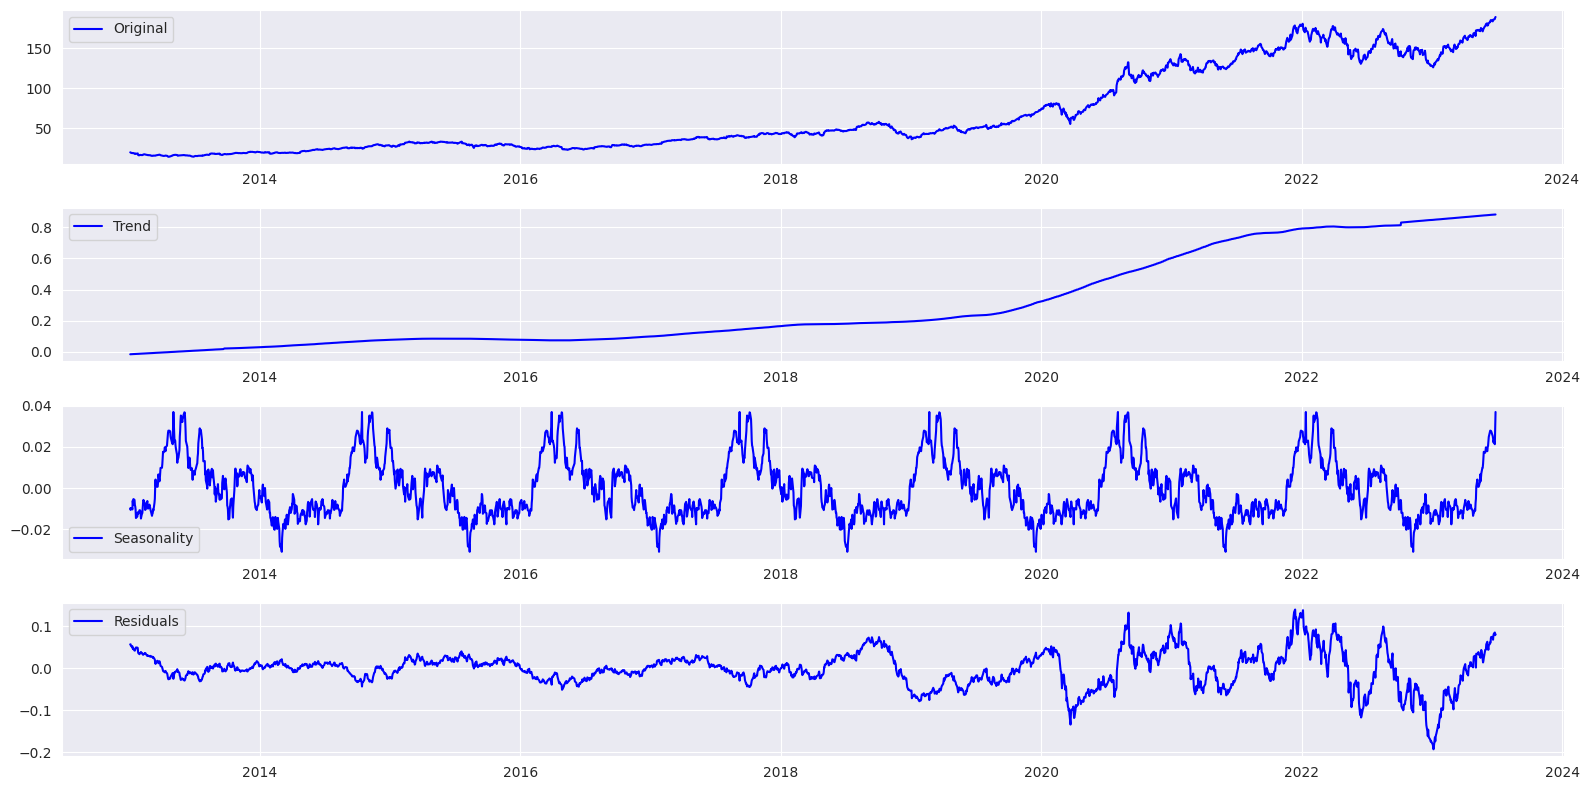

In [75]:
# ###Understanding the Time series data
# Decomposing Time Series into several components-Trend, Seasonality, and Random noise
#
# We know that Time series data is composed of Level, Trend, Seasonality, and Random noise. Let’s decompose the data and plot the trend, seasonality, and randomness in the data.
#
# We use statsmodel for seasonal decompose as an additive model and the frequency of the time series, which is the periodicity of the data, which is 365 days for yearly data.
#
# Additive model = Trend + Seasonality + Random Noise

from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(X['Mean'], model='add', period=365, extrapolate_trend='freq', two_sided=True, filt=None)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(16, 8))
plt.subplot(411)
plt.plot(df['Mean'], label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [76]:
###Check for Data Stationarity using Augmented Dickey-Fuller(ADF) test.

from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

def test_adf(series, title=''):
    dfout={}
    dftest = sm.tsa.adfuller(series.dropna(), autolag='AIC', regression='ct')
    for key,val in dftest[4].items():
        dfout[f'critical value ({key})']=val
    if dftest[1]<=0.05:
        print("Strong evidence against Null Hypothesis")
        print("Reject Null Hypothesis - Data is  Stationary")
        print("Data is Stationary", title)
    else:
        print("Strong evidence for  Null Hypothesis")
        print("Accept Null Hypothesis - Data is not Stationary")
        print("Data is NOT Stationary for", title)


In [77]:
#Checking for stationarity in the data using the ADF test

y_test = y['Stock Price Next Day'][:train_size].dropna()
test_adf(y_test, 'Stock Price Next Day')

Strong evidence for  Null Hypothesis
Accept Null Hypothesis - Data is not Stationary
Data is NOT Stationary for Stock Price Next Day


In [78]:
#Make the data stationary by differencing the data

y_test_diff = y_test.diff().dropna()
test_adf(y_test_diff, 'Stock Price Next Day')

Strong evidence against Null Hypothesis
Reject Null Hypothesis - Data is  Stationary
Data is Stationary Stock Price Next Day


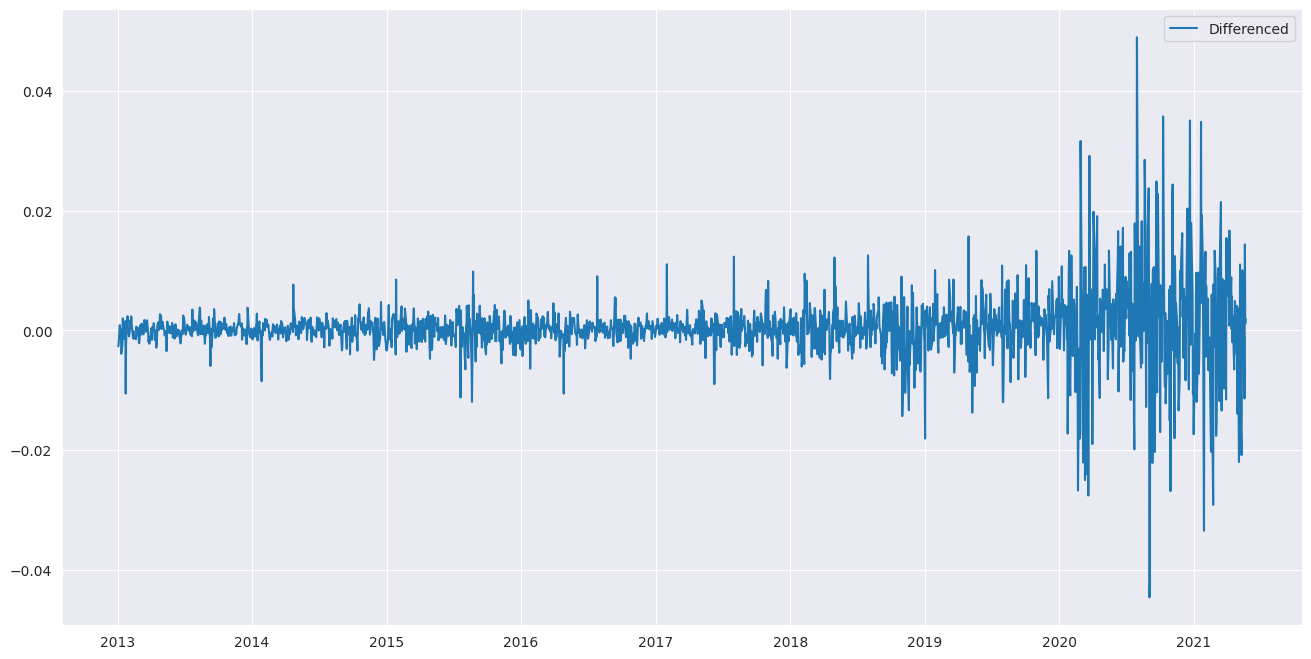

In [79]:
#Plotting the differenced data

plt.figure(figsize=(16, 8))
plt.plot(y_test_diff, label='Differenced')
plt.legend(loc='best')
plt.show()

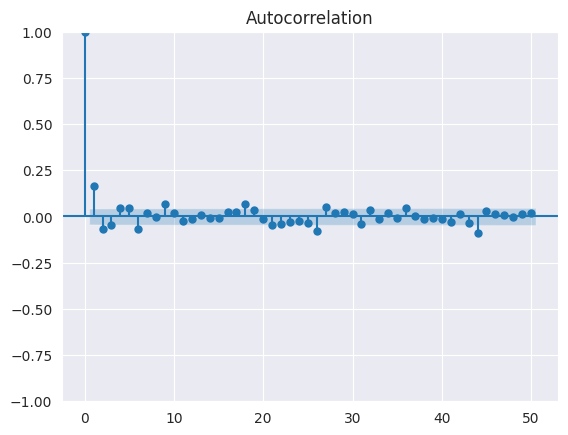

In [80]:
#Plotting the autocorrelation plot for the differenced data

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(y_test_diff, lags=50)
plt.show()

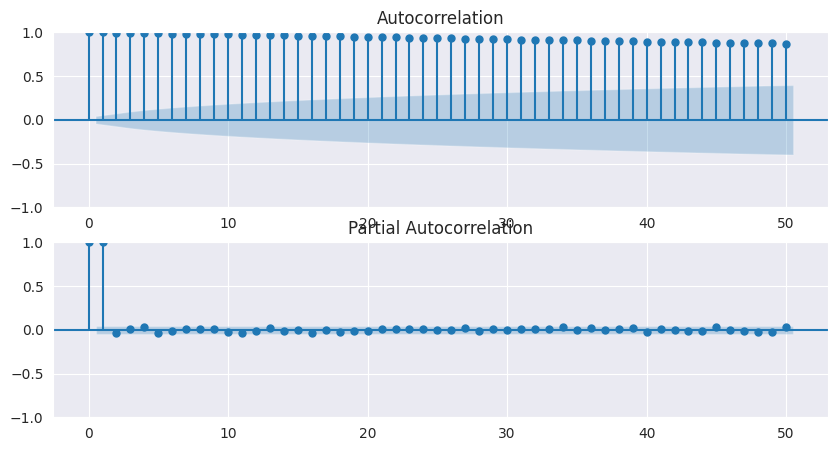

In [81]:
fig,ax= plt.subplots(2,1, figsize=(10,5))
fig=sm.tsa.graphics.plot_acf(y_test, lags=50, ax=ax[0])
fig=sm.tsa.graphics.plot_pacf(y_test, lags=50, ax=ax[1])
plt.show()

In [92]:
from pmdarima.arima import auto_arima

step_wise=auto_arima(train_Y,
 exogenous= train_X,
 start_p=1, start_q=1,
 max_p=7, max_q=7,
 d=1, max_d=7,
 trace=True,
 error_action="ignore",
 suppress_warnings=True,
 stepwise=True)

step_wise.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-16143.360, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-16076.672, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-16132.812, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-16142.637, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-16072.511, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-16147.754, Time=0.32 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-16149.954, Time=0.48 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-16148.641, Time=0.27 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-16146.988, Time=0.58 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-16146.635, Time=0.04 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0] intercept
Total fit time: 2.310 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2112
Model:               SARIMAX(2, 1, 0)   Log Likelihood                8078.977
Date:                Sun, 02 Jul 2023   AIC                         -16149.954
Time:                        19:28:18   BIC                         -16127.335
Sample:                             0   HQIC                        -16141.671
                               - 2112                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0003      0.000      2.297      0.022     3.9e-05       0.000
ar.L1          0.1804      0.009     20.287      0.000       0.163       0.198
ar.L2         -0.0950      0.011     -8.322      0.000      -0.117      -0.073
sigma2      2.775e-05   2.99e-07     92.731      0.000    2.72e-05    2.83e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             20019.44
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):              21.82   Skew:                             0.35
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [95]:
#Get the best parameters of seasonal orders for the SAIRMAX model using the auto_arima function from pmdarima library.

from pmdarima.arima import auto_arima

step_wise=auto_arima(train_Y, exogenous= train_X,
                       start_p=1, start_q=1,
                       max_p=7, max_q=7, m=7,
                       start_P=0, seasonal=True,
                       d=1, max_D=7, D=1, trace=True,
                       error_action='ignore',
                       suppress_warnings=True)

step_wise.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=-15804.020, Time=0.84 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=-14603.296, Time=0.07 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-15168.392, Time=0.09 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=-15761.858, Time=0.31 sec
 ARIMA(1,1,1)(0,1,0)[7]             : AIC=-14725.195, Time=0.13 sec
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=inf, Time=1.27 sec
 ARIMA(1,1,1)(0,1,2)[7]             : AIC=inf, Time=5.17 sec
 ARIMA(1,1,1)(1,1,0)[7]             : AIC=-15253.014, Time=0.71 sec
 ARIMA(1,1,1)(1,1,2)[7]             : AIC=inf, Time=7.07 sec
 ARIMA(1,1,0)(0,1,1)[7]             : AIC=inf, Time=1.72 sec
 ARIMA(2,1,1)(0,1,1)[7]             : AIC=-15763.419, Time=0.40 sec
 ARIMA(1,1,2)(0,1,1)[7]             : AIC=inf, Time=1.46 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=inf, Time=0.96 sec
 ARIMA(0,1,2)(0,1,1)[7]             : AIC=inf, Time=0.76 sec
 ARIMA(2,1,0)(0,1,1)[7]             : AIC=inf, Time=1.

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 2112
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 7)   Log Likelihood                7906.010
Date:                           Sun, 02 Jul 2023   AIC                         -15804.020
Time:                                   19:33:52   BIC                         -15781.414
Sample:                                        0   HQIC                        -15795.741
                                          - 2112                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3130      0.087     -3.590      0.000      -0.484      -0.142
ma.L1          0.4208      0.085      4.921      0.000       0.253       0.588
ma.S.L7       -0.7642      0.008    -94.506      0.000      -0.780      -0.748
sigma2      3.184e-05   3.73e-07     85.255      0.000    3.11e-05    3.26e-05
===================================================================================
Ljung-Box (L1) (Q):                  13.77   Jarque-Bera (JB):             18855.13
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              22.13   Skew:                            -0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [96]:
#Fitting the model

from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(endog=train_Y, exog=train_X, order=(1, 1, 1),seasonal_order=(0,1,1,7) , enforce_invertibility=False, enforce_stationarity=False)

/mnt/learning/last_project/fetch_data_stock/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/mnt/learning/last_project/fetch_data_stock/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [97]:
results = model.fit(maxiter=200, method='powell', disp=True, full_output=True, start_ar_lags=2)
results.summary()

/mnt/learning/last_project/fetch_data_stock/.venv/lib/python3.10/site-packages/statsmodels/base/optimizer.py:18: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method powell is: xtol, ftol, maxfun, start_direc. The list of unsupported keyword arguments passed include: start_ar_lags. After release 0.14, this will raise.
  warnings.warn(


Optimization terminated successfully.
         Current function value: -3.905317
         Iterations: 12
         Function evaluations: 1436


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:              Stock Price Next Day   No. Observations:                 2112
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 7)   Log Likelihood                8248.030
Date:                           Sun, 02 Jul 2023   AIC                         -16474.060
Time:                                   19:34:22   BIC                         -16411.939
Sample:                                        0   HQIC                        -16451.304
                                          - 2112                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
low            0.5749      0.014     39.919      0.000       0.547       0.603
high           0.2501      0.020     12.695      0.000       0.211       0.289
open          -0.2605      0.018    -14.299      0.000      -0.296      -0.225
close          0.8627      0.281      3.074      0.002       0.313       1.413
volume         0.0046      0.002      1.890      0.059      -0.000       0.009
adj_close     -0.0246      0.287     -0.086      0.932      -0.588       0.539
Mean          -0.4436      0.010    -44.689      0.000      -0.463      -0.424
ar.L1         -0.0791      0.012     -6.445      0.000      -0.103      -0.055
ma.L1         -0.9399      0.012    -75.658      0.000      -0.964      -0.916
ma.S.L7       -1.0075      0.002   -445.147      0.000      -1.012      -1.003
sigma2      2.196e-05   2.67e-07     82.143      0.000    2.14e-05    2.25e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):             15712.09
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):              22.45   Skew:                             0.30
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.9e+17. Standard errors may be unstable.
"""

In [98]:
#Predicting the values

predictions = results.predict(start=train_size, end=train_size+test_size+(steps)-1, exog=test_X)

#forcasting the value

forecast_1= results.forecast(steps=test_size-1, exog=test_X)

/mnt/learning/last_project/fetch_data_stock/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/mnt/learning/last_project/fetch_data_stock/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/mnt/learning/last_project/fetch_data_stock/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [99]:
#Plotting the predicted values

act= pd.DataFrame(scaler_output.iloc[train_size:, 0])
# act.info()
predictions=pd.DataFrame(predictions)
predictions.reset_index(drop=True, inplace=True)
predictions.index=test_X.index
predictions['Actual'] = act['Stock Price Next Day']
predictions.rename(columns={0:'Pred'}, inplace=True)

<Axes: xlabel='date'>

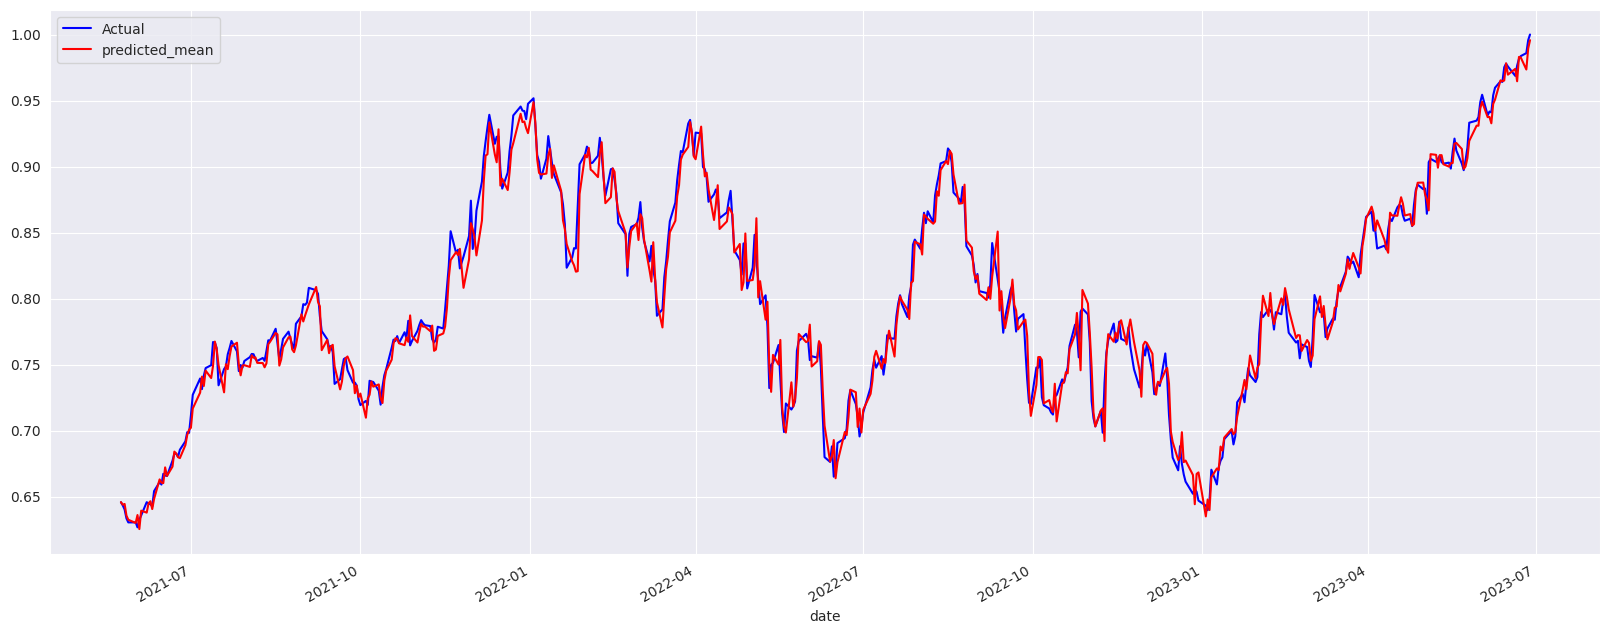

In [100]:
predictions["Actual"].plot(figsize=(20,8), legend=True, color="blue")
predictions["predicted_mean"].plot(legend=True, color="red", figsize=(20,8))

In [101]:
#Plotting the forecasted values

forecast_apple= pd.DataFrame(forecast_1)
forecast_apple.reset_index(drop=True, inplace=True)
forecast_apple.index=test_X.index
forecast_apple["Actual"] =scaler_output.iloc[train_size:, 0]
forecast_apple.rename(columns={0:"Forecast"}, inplace=True)

<Axes: xlabel='date'>

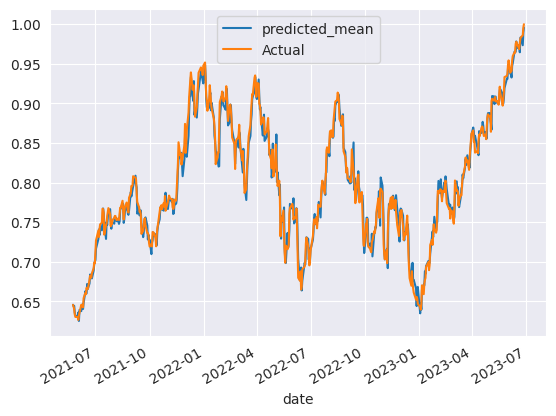

In [102]:
forecast_apple["predicted_mean"].plot(legend=True)
forecast_apple["Actual"].plot(legend=True)

In [103]:
from statsmodels.tools.eval_measures import rmse
error=rmse(predictions["predicted_mean"], predictions["Actual"])
error

0.011274888412714287

In [91]:
trainPredict = sc_out.inverse_transform(predictions[["predicted_mean"]])
testPredict = sc_out.inverse_transform(predictions[["Actual"]])